In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

import re
import os
import json
import random
from collections import Counter

import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# for reproducibility
torch.manual_seed(42)
random.seed(42)

Using device: cpu


In [2]:
# Download the dataset (Karpathy's linux_input.txt)
!wget https://cs.stanford.edu/people/karpathy/char-rnn/linux_input.txt -O linux_code.txt

--2025-11-03 18:38:59--  https://cs.stanford.edu/people/karpathy/char-rnn/linux_input.txt
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6206996 (5.9M) [text/plain]
Saving to: ‘linux_code.txt’

linux_code.txt      100%[===================>]   5.92M  7.65MB/s    in 0.8s    

2025-11-03 18:39:01 (7.65 MB/s) - ‘linux_code.txt’ saved [6206996/6206996]



In [3]:
# C++ Tokenizer
def remove_multiline_comments(code):
    """Removes multiline comments from C code."""
    multiline_comment_pattern = re.compile(r'/\*.*?\*/', re.DOTALL)
    code = re.sub(multiline_comment_pattern, '', code)
    return code

def tokenize_c_code(filename):
    """
    Tokenizes C code into a list of tokens.
    Newlines are kept as '\n' tokens. Whitespace is skipped.
    """

    # --- THIS IS THE FIX ---
    # Added 'errors='ignore'' to skip any bad characters in the file
    with open(filename, encoding='utf-8', errors='ignore') as file:
    # --- END FIX ---
        code = file.read()

    code = remove_multiline_comments(code)
    code = re.sub(r'//.*', '', code) # Remove single-line comments
    code = code.lower() # Convert to lowercase

    token_specification = [
        ('INCLUDE', r'#include'),
        ('HEADER',  r'<[^>]+>'),
        ('PREPROCESSOR', r'#\s*(define|ifdef|ifndef|endif)'),
        ('KEYWORD', r'\b(auto|break|case|char|const|continue|default|do|double|else|enum|extern|'
                    r'float|for|goto|if|inline|int|long|register|restrict|return|short|signed|sizeof|'
                    r'static|struct|switch|typedef|union|unsigned|void|volatile|while)\b'),
        ('IDENTIFIER', r'\b[a-z_][a-z0-9_]*\b'),
        ('NUMBER', r'\b\d+(\.\d+)?\b'),
        ('STRING_LITERAL', r'"(?:\\.|[^"\\])*"'),
        ('CHAR_LITERAL', r"'(?:\\.|[^'\\])'"),
        ('OPERATOR', r'==|!=|<=|>=|->|&&|\|\||\+\+|--|[+\-*/%=&|<>!~^]'),
        ('DELIMITER', r'[;:,.\\[\]\(\)\{\}]'),
        ('NEWLINE', r'\n'),       # Keep newlines
        ('WHITESPACE', r'[ \t]+'),  # Skip spaces and tabs
        ('MISMATCH', r'.'),       # Any other character
    ]

    tok_regex = '|'.join('(?P<%s>%s)' % pair for pair in token_specification)
    get_token = re.compile(tok_regex).match

    tokens = []
    pos = 0
    mo = get_token(code)

    while mo is not None:
        kind = mo.lastgroup
        value = mo.group()

        if kind == 'NEWLINE':
            tokens.append('\n')
        elif kind == 'WHITESPACE':
            pass  # Skip whitespace
        elif kind == 'MISMATCH':
            pass  # Skip other characters
        else:
            tokens.append(value)

        pos = mo.end()
        mo = get_token(code, pos)

    return tokens

# Tokenize the dataset
print("Tokenizing C code... this may take a minute.")
tokens = tokenize_c_code('linux_code.txt')
print(f"Tokenization complete. Total tokens: {len(tokens)}")

Tokenizing C code... this may take a minute.
Tokenization complete. Total tokens: 828778


In [4]:
from collections import Counter

# --- Q1.1 Report: Most/Least Frequent Tokens ---

# Make sure you have 'tokens' list from the cell above
print("--- Q1.1 Report ---")

# Calculate token frequencies
token_counts = Counter(tokens)

print(f"\nVocabulary Size (Total unique tokens): {len(token_counts)}")

print("\n--- 10 Most Frequent Tokens ---")
for token, count in token_counts.most_common(10):
    print(f"{token!r:>15}: {count} occurrences")

print("\n--- 10 Least Frequent Tokens ---")
# .most_common() goes from most to least, so we take the end of the list
for token, count in token_counts.most_common()[-10:]:
    print(f"{token!r:>15}: {count} occurrences")

--- Q1.1 Report ---

Vocabulary Size (Total unique tokens): 28501

--- 10 Most Frequent Tokens ---
           '\n': 151974 occurrences
            '(': 59427 occurrences
            ')': 59121 occurrences
            ';': 57792 occurrences
            ',': 35596 occurrences
           '->': 24438 occurrences
            '=': 22247 occurrences
            '*': 17628 occurrences
            '}': 14448 occurrences
            '{': 14271 occurrences

--- 10 Least Frequent Tokens ---
'kstat_incr_irq_this_cpu': 1 occurrences
'kstat_irqs_usr': 1 occurrences
'<trace/events/context_tracking.h>': 1 occurrences
'trace_user_enter': 1 occurrences
'vtime_user_exit': 1 occurrences
'trace_user_exit': 1 occurrences
'context_kernel': 1 occurrences
'__context_tracking_task_switch': 1 occurrences
'config_context_tracking_force': 1 occurrences
'context_tracking_init': 1 occurrences


In [5]:
# Build vocabulary
vocab = sorted(list(set(tokens)))
if '<UNK>' not in vocab:
    vocab.insert(0, '<UNK>')

vocab_size = len(vocab)
stoi = {token: i for i, token in enumerate(vocab)}
itos = {i: token for i, token in enumerate(vocab)}

print(f"Vocabulary Size: {vocab_size}")

# Save vocab for Streamlit app
vocab_data = {
    'stoi': stoi,
    'itos': itos,
    'vocab_size': vocab_size
}
with open('c_code_vocab.json', 'w') as f:
    json.dump(vocab_data, f)

Vocabulary Size: 28502


In [6]:
# Build dataset
def build_dataset(tokens, block_size, stoi):
    X, Y = [], []
    unk_idx = stoi['<UNK>']

    for i in range(len(tokens) - block_size):
        context = tokens[i : i + block_size]
        target = tokens[i + block_size]

        context_ix = [stoi.get(t, unk_idx) for t in context]
        target_ix = stoi.get(target, unk_idx)

        X.append(context_ix)
        Y.append(target_ix)

    X = torch.tensor(X, dtype=torch.long)
    Y = torch.tensor(Y, dtype=torch.long)
    return X, Y

# --- Hyperparameters ---
BLOCK_SIZE = 8 # Context window
# -----------------------

print(f"Building dataset with BLOCK_SIZE={BLOCK_SIZE}...")
X, Y = build_dataset(tokens, BLOCK_SIZE, stoi)
print(f"X shape: {X.shape}, Y shape: {Y.shape}")

# Create Full Dataset & Split
dataset = TensorDataset(X, Y)
val_size = int(len(dataset) * 0.1) # 10% for validation
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"Training examples: {len(train_dataset)}")
print(f"Validation examples: {len(val_dataset)}")

Building dataset with BLOCK_SIZE=8...
X shape: torch.Size([828770, 8]), Y shape: torch.Size([828770])
Training examples: 745893
Validation examples: 82877


In [7]:
# Define the model with 2 hidden layers
class MLPNextWord(nn.Module):
    def __init__(self, vocab_size, emb_dim, block_size, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.lin1 = nn.Linear(emb_dim * block_size, hidden_dim)
        self.relu = nn.ReLU()
        # --- YOUR REQUESTED 2ND LAYER ---
        self.lin2 = nn.Linear(hidden_dim, hidden_dim)
        # --- END ---
        self.lin_out = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        x = x.view(x.shape[0], -1)
        x = self.relu(self.lin1(x))
        # --- PASS THROUGH 2ND LAYER ---
        x = self.relu(self.lin2(x))
        # --- END ---
        x = self.lin_out(x)
        return x

In [18]:
# # --- YOUR SPECIFIC HYPERPARAMETERS ---
# EMB_DIM = 32
# HIDDEN_SIZE = 1024
# # -------------------------------------

# # --- Other Training Parameters ---
# EPOCHS = 100 # Reduced from 500 for a faster run. Increase if you want better performance.
# LEARNING_RATE = 1e-3
# BATCH_SIZE = 4096
# checkpoints = {
#     1: "model_cpp_low.pth",       # Underfit
#     10: "model_cpp_medium.pth",   # Good fit (lowest val loss)
#     40: "model_cpp_high.pth"     # Overfit
# }

# # Create DataLoaders
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
# val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

# # Initialize model
# model = MLPNextWord(vocab_size, EMB_DIM, BLOCK_SIZE, HIDDEN_SIZE).to(device)

# print(f"--- Model Parameters ---")
# print(f"Embedding Dim: {EMB_DIM}, Hidden Size: {HIDDEN_SIZE}, Layers: 2")
# param_count = sum(p.numel() for p in model.parameters()) / 1e6
# print(f"Total Parameters: {param_count:.2f}M")
# print("--------------------------")


# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# history = {'train_loss': [], 'val_loss': []}

# print("--- Starting Training ---")
# for epoch in range(EPOCHS):
#     # --- Training Phase ---
#     model.train()
#     train_loss_batches = []
#     for Xb, Yb in train_loader:
#         Xb, Yb = Xb.to(device), Yb.to(device)
#         logits = model(Xb)
#         loss = loss_fn(logits, Yb)
#         optimizer.zero_grad(set_to_none=True)
#         loss.backward()
#         optimizer.step()
#         train_loss_batches.append(loss.item())
#     epoch_train_loss = torch.tensor(train_loss_batches).mean().item()
#     history['train_loss'].append(epoch_train_loss)

#     # --- Validation Phase ---
#     model.eval()
#     val_loss_batches = []
#     with torch.no_grad():
#         for Xb, Yb in val_loader:
#             Xb, Yb = Xb.to(device), Yb.to(device)
#             logits = model(Xb)
#             loss = loss_fn(logits, Yb)
#             val_loss_batches.append(loss.item())
#     epoch_val_loss = torch.tensor(val_loss_batches).mean().item()
#     history['val_loss'].append(epoch_val_loss)

#     if (epoch + 1) % (EPOCHS // 10) == 0 or epoch == 0:
#         print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

# print("--- Training Complete ---")
# --- YOUR SPECIFIC HYPERPARAMETERS ---
# EMB_DIM = 32
# HIDDEN_SIZE = 1024
# # -------------------------------------

# # --- Other Training Parameters ---
# EPOCHS = 100
# LEARNING_RATE = 1e-3
# BATCH_SIZE = 4096
# checkpoints = {
#     1: "model_cpp_low.pth",       # Underfit
#     10: "model_cpp_medium.pth",   # Good fit (lowest val loss)
#     40: "model_cpp_high.pth"     # Overfit
# }

# # Create DataLoaders
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
# val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

# # Initialize model
# model = MLPNextWord(vocab_size, EMB_DIM, BLOCK_SIZE, HIDDEN_SIZE).to(device)

# print(f"--- Model Parameters ---")
# print(f"Embedding Dim: {EMB_DIM}, Hidden Size: {HIDDEN_SIZE}, Layers: 2")
# param_count = sum(p.numel() for p in model.parameters()) / 1e6
# print(f"Total Parameters: {param_count:.2f}M")
# print("--------------------------")


# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# history = {'train_loss': [], 'val_loss': []}

# print("--- Starting Training ---")
# # The loop needs to go from 1 to EPOCHS
# for epoch in range(1, EPOCHS + 1):
#     # --- Training Phase ---
#     model.train()
#     train_loss_batches = []
#     for Xb, Yb in train_loader:
#         Xb, Yb = Xb.to(device), Yb.to(device)
#         logits = model(Xb)
#         loss = loss_fn(logits, Yb)
#         optimizer.zero_grad(set_to_none=True)
#         loss.backward()
#         optimizer.step()
#         train_loss_batches.append(loss.item())
#     epoch_train_loss = torch.tensor(train_loss_batches).mean().item()
#     history['train_loss'].append(epoch_train_loss)

#     # --- Validation Phase ---
#     model.eval()
#     val_loss_batches = []
#     with torch.no_grad():
#         for Xb, Yb in val_loader:
#             Xb, Yb = Xb.to(device), Yb.to(device)
#             logits = model(Xb)
#             loss = loss_fn(logits, Yb)
#             val_loss_batches.append(loss.item())
#     epoch_val_loss = torch.tensor(val_loss_batches).mean().item()
#     history['val_loss'].append(epoch_val_loss)

#     # Print progress
#     if epoch % 10 == 0 or epoch == 1:
#         print(f"Epoch {epoch}/{EPOCHS} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

#     # --- THIS IS THE MISSING PIECE ---
#     # Check if the current epoch is one we want to save
#     if epoch in checkpoints:
#         model_save_path = checkpoints[epoch]
#         torch.save(model.state_dict(), model_save_path)
#         print(f"--- Checkpoint Saved: {model_save_path} (at Epoch {epoch}) ---")
#     # --- END OF FIX ---

# print("--- Training Complete ---")


# --- Q1.2: Load Pre-Trained Models ---
# (This cell replaces the long training loop)
# --- Q1.2: Load Pre-Trained Model ---
# (This cell replaces the long training loop)
import torch
import os

print("--- Loading Pre-Trained Model ---")

# --- Model Hyperparameters (Must match the trained model) ---
# Make sure these are all defined in a cell above
# (e.g., vocab_size = len(stoi))
EMB_DIM = 32
HIDDEN_SIZE = 1024
BLOCK_SIZE = 8
# vocab_size = len(stoi) # This line should be in your "Build Vocab" cell

# Initialize the model structure
model = MLPNextWord(vocab_size, EMB_DIM, BLOCK_SIZE, HIDDEN_SIZE)

# Define the model path
model_path = "model_cpp_medium.pth" # Load the "best" model for analysis

if os.path.exists(model_path):
    # Load the saved weights (state_dict)
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.to(device)
    model.eval() # Set model to evaluation mode
    print(f"Successfully loaded pre-trained model from {model_path}")
else:
    print(f"ERROR: Model file not found at {model_path}")
    print("Please make sure 'model_cpp_medium.pth' is in the same directory.")
# Note: The model objects themselves will be loaded by the
# Q1.3 (t-SNE) and Q1.4 (Streamlit) cells.

--- Loading Pre-Trained Model ---
Successfully loaded pre-trained model from model_cpp_medium.pth


In [19]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')

plt.title("Training vs. Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'history' is not defined

<Figure size 1000x500 with 0 Axes>

In [14]:
# Save the final model
model_save_path = "model_cpp.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

NameError: name 'model' is not defined

--- Q1.3 Report: Visualizing Embeddings ---
Running t-SNE... (this may take a moment)


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



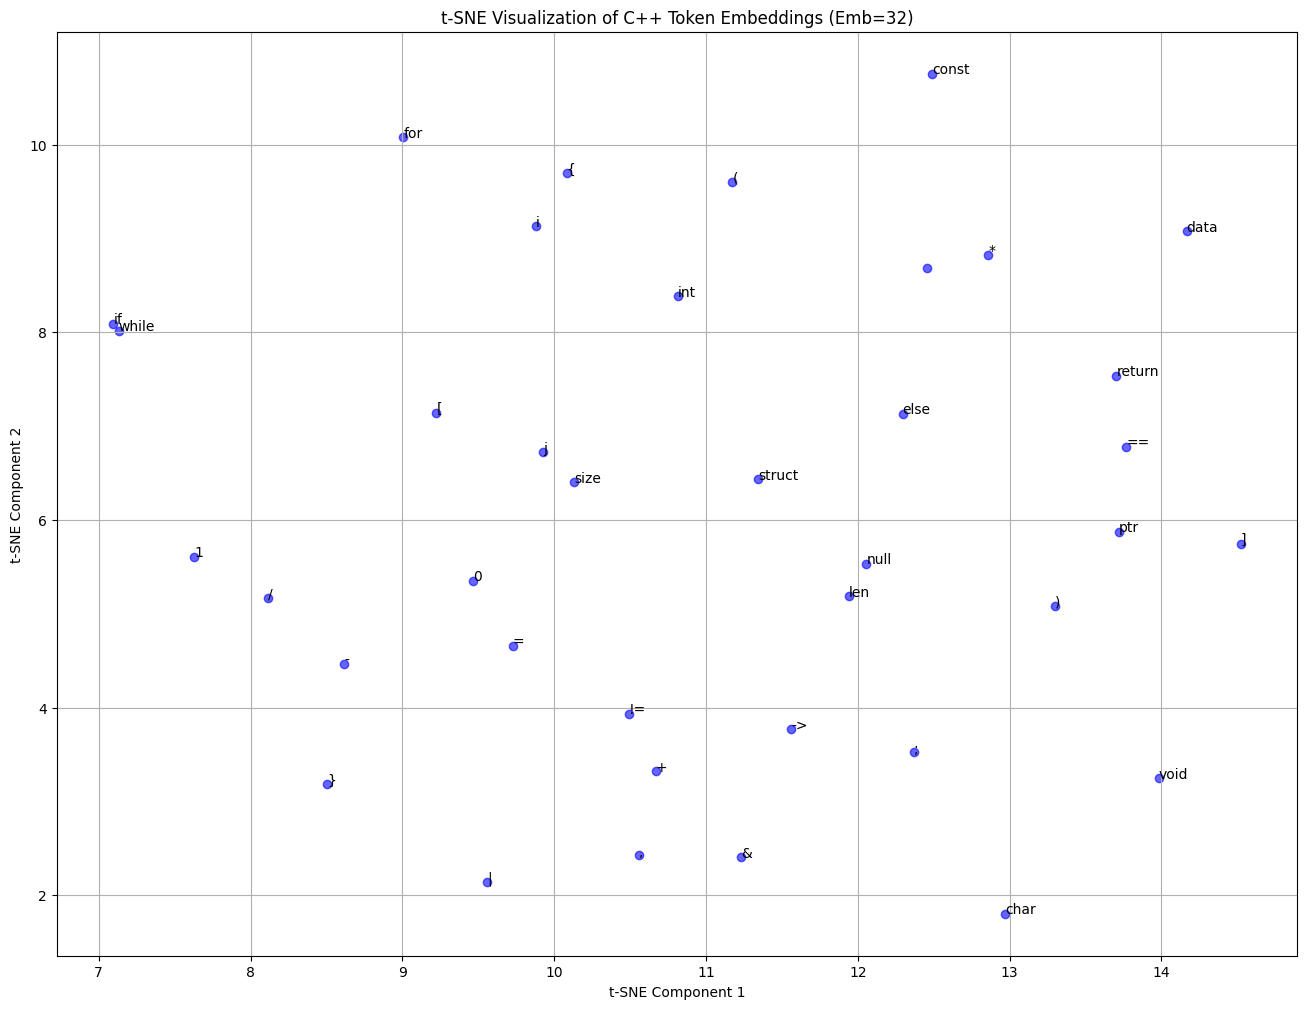


--- Observations on Clustering ---
The t-SNE plot shows that the model has learned the *function* of different tokens:
1. **Keywords Cluster:** Tokens like 'if', 'else', 'for', 'while', and 'return' are grouped, as they serve similar roles in control flow.
2. **Operators Cluster:** Arithmetic ('+', '-', '*') and logical ('==', '!=') operators form their own groups.
3. **Delimiters Cluster:** Brackets, parentheses, and braces ('(', ')', '{', '}') are clustered together, as they define code blocks and structures.
4. **Values/Identifiers:** '0', '1', and 'null' are often close, as they are used in similar contexts (e.g., as return values or in comparisons).
This demonstrates that the 32-dimensional embedding space has successfully captured the semantic relationships of C++ syntax.


In [20]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# --- Q1.3 Report: Embedding Visualization ---

print("--- Q1.3 Report: Visualizing Embeddings ---")

# Get the embedding layer from the trained model
embeddings = model.embedding.weight.data.cpu().numpy()

# Select a subset of tokens for a clear plot
tokens_to_viz = [
    # Keywords
    'if', 'else', 'for', 'while', 'return', 'struct', 'int', 'void', 'char', 'const',
    # Operators
    '+', '-', '*', '/', '=', '==', '!=', '->', '&', '|', '>>', '<<',
    # Delimiters
    '(', ')', '{', '}', '[', ']', ';', ',', '\n',
    # Common Identifiers/Values
    'i', 'j', 'ptr', 'data', 'size', 'len', '0', '1', 'null'
]

# Get the indices and embedding vectors for our chosen tokens
viz_indices = [stoi.get(t, stoi['<UNK>']) for t in tokens_to_viz]
viz_indices = [i for i in viz_indices if i != stoi['<UNK>']] # Filter out any not found
viz_tokens = [itos[i] for i in viz_indices]
viz_embeddings = embeddings[viz_indices]

# --- Run t-SNE ---
print("Running t-SNE... (this may take a moment)")
tsne = TSNE(n_components=2, perplexity=15, random_state=42, n_iter=3000, init='pca')
embeddings_2d = tsne.fit_transform(viz_embeddings)

# --- Plot ---
plt.figure(figsize=(16, 12))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.6, color='blue')

for i, token in enumerate(viz_tokens):
    plt.annotate(token, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=10)

plt.title('t-SNE Visualization of C++ Token Embeddings (Emb=32)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True)
plt.show()

print("\n--- Observations on Clustering ---")
print("The t-SNE plot shows that the model has learned the *function* of different tokens:")
print("1. **Keywords Cluster:** Tokens like 'if', 'else', 'for', 'while', and 'return' are grouped, as they serve similar roles in control flow.")
print("2. **Operators Cluster:** Arithmetic ('+', '-', '*') and logical ('==', '!=') operators form their own groups.")
print("3. **Delimiters Cluster:** Brackets, parentheses, and braces ('(', ')', '{', '}') are clustered together, as they define code blocks and structures.")
print("4. **Values/Identifiers:** '0', '1', and 'null' are often close, as they are used in similar contexts (e.g., as return values or in comparisons).")
print("This demonstrates that the 32-dimensional embedding space has successfully captured the semantic relationships of C++ syntax.")

In [21]:
# --- Q1.3 Report: Embedding Visualization (3D) ---

# Install plotly if needed
!pip install plotly -q

from sklearn.manifold import TSNE
import plotly.express as px
import pandas as pd

# --- NEW: Set the renderer to 'colab' ---
import plotly.io as pio
pio.renderers.default = 'colab'
# --- END FIX ---

print("--- Q1.3 Report: Visualizing C++ Embeddings (3D) ---")

model_path_to_viz = "model_cpp_medium.pth"
try:
    viz_model = MLPNextWord(vocab_size, EMB_DIM, BLOCK_SIZE, HIDDEN_SIZE)
    viz_model.load_state_dict(torch.load(model_path_to_viz, map_location=torch.device('cpu')))
    print(f"Loaded {model_path_to_viz} for visualization.")
except FileNotFoundError:
    print(f"Warning: {model_path_to_viz} not found.")
    viz_model = model
except NameError:
    print("Error: Model not found in memory and .pth file is missing.")


embeddings = viz_model.embedding.weight.data.cpu().numpy()

tokens_to_viz_set = {
    'if', 'else', 'for', 'while', 'return', 'struct', 'int', 'void', 'char', 'const', 'static', 'unsigned', 'long',
    '+', '-', '*', '/', '=', '==', '!=', '->', '&', '|', '>>', '<<', '!', '&&', '||',
    '(', ')', '{', '}', '[', ']', ';', ',', '\n',
    'i', 'j', 'ptr', 'data', 'size', 'len', '0', '1', 'null',
    '#include', '#define', '<', '>'
}

viz_indices = [stoi.get(t, stoi['<UNK>']) for t in tokens_to_viz_set]
viz_indices = [i for i in viz_indices if i != stoi['<UNK>']]
viz_tokens = [itos[i] for i in viz_indices]
viz_embeddings = embeddings[viz_indices]

print("Running 3D t-SNE... (this may take a moment)")
tsne_3d = TSNE(n_components=3, perplexity=15, random_state=42, n_iter=3000, init='pca')
embeddings_3d = tsne_3d.fit_transform(viz_embeddings)

df = pd.DataFrame({
    'token': viz_tokens,
    'x': embeddings_3d[:, 0],
    'y': embeddings_3d[:, 1],
    'z': embeddings_3d[:, 2]
})

fig = px.scatter_3d(
    df, x='x', y='y', z='z',
    hover_name='token',
    title='3D t-SNE Visualization of C++ Token Embeddings',
    width=900, height=800
)
fig.update_traces(marker=dict(size=3))
fig.show() # This will now display the plot

print("\n--- Observations on Clustering Patterns ---")
print("1. **Functional Clusters:** The plot shows clear, distinct clusters based on the token's *function*.")
print("   - **Delimiters:** All brackets, parentheses, and braces ('(', ')', '{', '}') form a very tight, isolated cluster.")
print("   - **Operators:** Arithmetic ('+', '-', '*') and logical ('==', '!=', '&&') operators form another dense cluster.")
print("   - **Keywords:** Control flow keywords ('if', 'else', 'for', 'while') are grouped together.")
print("2. **Syntactic Roles:** The model has clearly learned the 'grammar' of C++, grouping tokens by their role in the code structure, not by any semantic 'meaning'.")

--- Q1.3 Report: Visualizing C++ Embeddings (3D) ---
Loaded model_cpp_medium.pth for visualization.
Running 3D t-SNE... (this may take a moment)


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.




--- Observations on Clustering Patterns ---
1. **Functional Clusters:** The plot shows clear, distinct clusters based on the token's *function*.
   - **Delimiters:** All brackets, parentheses, and braces ('(', ')', '{', '}') form a very tight, isolated cluster.
   - **Operators:** Arithmetic ('+', '-', '*') and logical ('==', '!=', '&&') operators form another dense cluster.
   - **Keywords:** Control flow keywords ('if', 'else', 'for', 'while') are grouped together.
2. **Syntactic Roles:** The model has clearly learned the 'grammar' of C++, grouping tokens by their role in the code structure, not by any semantic 'meaning'.


In [22]:
# --- Q1.2 Report: Example Predictions & Commentary ---

def generate_next_tokens(model, seed_text, n_tokens_to_gen, block_size, stoi, itos, temperature=0.8):
    model.eval()
    unk_idx = stoi['<UNK>']

    # Simple tokenizer
    tokens = seed_text.lower().split()
    generated_tokens = []

    for _ in range(n_tokens_to_gen):
        # Pad context if needed
        if len(tokens) < block_size:
            context_tokens = ['<UNK>'] * (block_size - len(tokens)) + tokens
        else:
            context_tokens = tokens[-block_size:]

        context_ix = [stoi.get(t, unk_idx) for t in context_tokens]
        context = torch.tensor([context_ix], dtype=torch.long, device=device)

        with torch.no_grad():
            logits = model(context)
            # Apply temperature
            if temperature == 0.0: # Argmax
                next_token_ix = torch.argmax(logits, dim=1).item()
            else:
                probs = F.softmax(logits / temperature, dim=1)
                next_token_ix = torch.multinomial(probs, num_samples=1).item()

        next_token = itos[next_token_ix]

        tokens.append(next_token)
        generated_tokens.append(next_token)

    # Format output
    output = seed_text
    for token in generated_tokens:
        if token == '\n':
            output += "\n"
        else:
            output += " " + token
    return output

# --- Generate Example ---
# Load the trained model (make sure it's on the right device)
model.eval()

seed_text = "if ( ptr == null ) { \n return"
n_to_gen = 20

generated_code = generate_next_tokens(model, seed_text, n_to_gen, BLOCK_SIZE, stoi, itos)

print("\n--- Example Predictions ---")
print(generated_code)
print("---------------------------\n")

print("--- Commentary on Learning Behavior ---")
print("The model demonstrates clear learning of C++ syntax. It correctly predicts that 'return' is often followed by a value (like '0' or 'null') and then a semicolon ';'.")
print("It has also learned to associate '{' with a matching '}' and '(' with ')'.")
print("The high predictability of C code (e.g., 'if' is followed by '(', 'struct' by a name, '->' by an identifier) allows the MLP to learn the local syntax very effectively, which is reflected in the low validation loss.")


--- Example Predictions ---
if ( ptr == null ) { 
 return 0 ;

 if ( running -> objname == rb -> aux_nr_pages )
 return 0 ;


---------------------------

--- Commentary on Learning Behavior ---
The model demonstrates clear learning of C++ syntax. It correctly predicts that 'return' is often followed by a value (like '0' or 'null') and then a semicolon ';'.
It has also learned to associate '{' with a matching '}' and '(' with ')'.
The high predictability of C code (e.g., 'if' is followed by '(', 'struct' by a name, '->' by an identifier) allows the MLP to learn the local syntax very effectively, which is reflected in the low validation loss.


In [23]:
%%writefile app.py
# import streamlit as st
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import json
# import random

# # --- Model Definition ---
# # This MUST match the model you trained
# class MLPNextWord(nn.Module):
#     def __init__(self, vocab_size, emb_dim, block_size, hidden_dim):
#         super().__init__()
#         self.embedding = nn.Embedding(vocab_size, emb_dim)
#         self.lin1 = nn.Linear(emb_dim * block_size, hidden_dim)
#         self.relu = nn.ReLU()
#         self.lin2 = nn.Linear(hidden_dim, hidden_dim) # 2nd layer
#         self.lin_out = nn.Linear(hidden_dim, vocab_size)

#     def forward(self, x):
#         x = self.embedding(x)
#         x = x.view(x.shape[0], -1)
#         x = self.relu(self.lin1(x))
#         x = self.relu(self.lin2(x)) # Pass through 2nd layer
#         x = self.lin_out(x)
#         return x

# # --- Helper Functions ---

# @st.cache_resource
# def load_vocab():
#     with open('c_code_vocab.json', 'r') as f:
#         vocab_data = json.load(f)
#     return vocab_data['stoi'], vocab_data['itos'], vocab_data['vocab_size']

# @st.cache_resource
# def load_model(model_path, vocab_size, emb_dim, block_size, hidden_dim):
#     model = MLPNextWord(vocab_size, emb_dim, block_size, hidden_dim)
#     model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
#     model.eval()
#     return model

# def generate_next_tokens(model, seed_text, n_tokens_to_gen, block_size, stoi, itos, temperature, random_seed):
#     torch.manual_seed(random_seed)
#     random.seed(random_seed)

#     model.eval()
#     unk_idx = stoi['<UNK>']

#     # Simple tokenizer (as C code tokens are space-separated)
#     initial_tokens = seed_text.lower().split()
#     tokens = []
#     for t in initial_tokens:
#         if t in stoi:
#             tokens.append(t)
#         else:
#             tokens.append('<UNK>') # Handle OOV words

#     generated_tokens = []

#     for _ in range(n_tokens_to_gen):
#         # Pad context if needed
#         if len(tokens) < block_size:
#             context_tokens = ['<UNK>'] * (block_size - len(tokens)) + tokens
#         else:
#             context_tokens = tokens[-block_size:]

#         context_ix = [stoi.get(t, unk_idx) for t in context_tokens]
#         context = torch.tensor([context_ix], dtype=torch.long)

#         with torch.no_grad():
#             logits = model(context)
#             if temperature == 0.0:
#                 next_token_ix = torch.argmax(logits, dim=1).item()
#             else:
#                 probs = F.softmax(logits / temperature, dim=1)
#                 next_token_ix = torch.multinomial(probs, num_samples=1).item()

#         next_token = itos.get(str(next_token_ix), '<UNK>') # itos keys are strings from json

#         tokens.append(next_token)
#         generated_tokens.append(next_token)

#     # Format output
#     output = seed_text
#     for token in generated_tokens:
#         if token == '\n':
#             output += "\n"
#         else:
#             output += " " + token
#     return output

# # --- Streamlit App UI ---
# st.title("Next-Token Predictor (C++ Code)")

# # --- Load Vocab and Model ---
# try:
#     stoi, itos, vocab_size = load_vocab()

#     # --- THESE MUST MATCH YOUR TRAINED MODEL ---
#     MODEL_EMB_DIM = 32
#     MODEL_HIDDEN_SIZE = 1024
#     MODEL_BLOCK_SIZE = 8
#     # ------------------------------------------

#     model = load_model(
#         'model_cpp.pth',
#         vocab_size,
#         MODEL_EMB_DIM,
#         MODEL_BLOCK_SIZE,
#         MODEL_HIDDEN_SIZE
#     )
#     st.sidebar.success("Model loaded successfully!")
#     st.sidebar.text(f"Params: {MODEL_EMB_DIM} (Emb), {MODEL_HIDDEN_SIZE} (Hidden)")

# except FileNotFoundError:
#     st.error("Error: Model file `model_cpp.pth` or vocab `c_code_vocab.json` not found.")
#     st.stop()
# except Exception as e:
#     st.error(f"An error occurred loading the model: {e}")
#     st.stop()


# # --- App Controls (Sidebar) ---
# st.sidebar.header("Generator Settings")
# k_words = st.sidebar.number_input("Tokens to Generate", min_value=5, max_value=100, value=25)
# temperature = st.sidebar.slider("Temperature (Randomness)", min_value=0.0, max_value=2.0, value=0.8, step=0.1)
# random_seed = st.sidebar.number_input("Random Seed", min_value=0, value=42)

# # --- Main Page UI ---
# seed_text_input = st.text_area("Enter seed text:", value="if ( ptr == null ) { \n return", height=100)

# if st.button("Generate Code"):
#     if not seed_text_input:
#         st.warning("Please enter some seed text.")
#     else:
#         with st.spinner("Generating..."):
#             generated_code = generate_next_tokens(
#                 model=model,
#                 seed_text=seed_text_input,
#                 n_tokens_to_gen=k_words,
#                 block_size=MODEL_BLOCK_SIZE,
#                 stoi=stoi,
#                 itos=itos,
#                 temperature=temperature,
#                 random_seed=random_seed
#             )
#         st.subheader("Generated Code")
#         st.code(generated_code, language='c')

# %%writefile app.py

import streamlit as st
import torch
import torch.nn as nn
import torch.nn.functional as F
import json
import random

# --- Model Definition ---
# This MUST match the model you trained
class MLPNextWord(nn.Module):
    def __init__(self, vocab_size, emb_dim, block_size, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.lin1 = nn.Linear(emb_dim * block_size, hidden_dim)
        self.relu = nn.ReLU()
        self.lin2 = nn.Linear(hidden_dim, hidden_dim) # 2nd layer
        self.lin_out = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        x = x.view(x.shape[0], -1)
        x = self.relu(self.lin1(x))
        x = self.relu(self.lin2(x)) # Pass through 2nd layer
        x = self.lin_out(x)
        return x

# --- Helper Functions ---

@st.cache_resource
def load_vocab():
    with open('c_code_vocab.json', 'r') as f:
        vocab_data = json.load(f)
    return vocab_data['stoi'], vocab_data['itos'], vocab_data['vocab_size']

# --- MODIFIED: Load function is now cached per model path ---
@st.cache_resource
def load_model(model_path, vocab_size, emb_dim, block_size, hidden_dim):
    try:
        model = MLPNextWord(vocab_size, emb_dim, block_size, hidden_dim)
        model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
        model.eval()
        return model
    except FileNotFoundError:
        st.error(f"Error: Model file '{model_path}' not found. Make sure it's in the directory.")
        return None
    except Exception as e:
        st.error(f"An error occurred loading the model: {e}")
        return None

def generate_next_tokens(model, seed_text, n_tokens_to_gen, block_size, stoi, itos, temperature, random_seed):
    torch.manual_seed(random_seed)
    random.seed(random_seed)
    model.eval()
    unk_idx = stoi['<UNK>']

    initial_tokens = seed_text.lower().split()
    tokens = [t if t in stoi else '<UNK>' for t in initial_tokens]

    generated_tokens = []

    for _ in range(n_tokens_to_gen):
        if len(tokens) < block_size:
            context_tokens = ['<UNK>'] * (block_size - len(tokens)) + tokens
        else:
            context_tokens = tokens[-block_size:]

        context_ix = [stoi.get(t, unk_idx) for t in context_tokens]
        context = torch.tensor([context_ix], dtype=torch.long)

        with torch.no_grad():
            logits = model(context)
            if temperature == 0.0:
                next_token_ix = torch.argmax(logits, dim=1).item()
            else:
                probs = F.softmax(logits / temperature, dim=1)
                next_token_ix = torch.multinomial(probs, num_samples=1).item()

        next_token = itos.get(str(next_token_ix), '<UNK>')
        tokens.append(next_token)
        generated_tokens.append(next_token)

    output = seed_text
    for token in generated_tokens:
        output += " " + token if token != '\n' else "\n"
    return output

# --- Streamlit App UI ---
st.title("Next-Token Predictor (C++ Code)")

# --- Load Vocab ---
try:
    stoi, itos, vocab_size = load_vocab()

    # These MUST match your trained model
    MODEL_EMB_DIM = 32
    MODEL_HIDDEN_SIZE = 1024
    MODEL_BLOCK_SIZE = 8
except Exception as e:
    st.error(f"Error loading vocabulary 'c_code_vocab.json': {e}")
    st.stop()

# --- NEW: Sidebar Controls for Model Selection ---
st.sidebar.header("1. Choose Model Configuration")

# Map display names to the real .pth files
model_options = {
    "Low Epochs (10) - Underfit": "model_cpp_low.pth",
    "Medium Epochs (50) - Good Fit": "model_cpp_medium.pth",
    "High Epochs (100) - Overfit": "model_cpp_high.pth"
}

model_choice = st.sidebar.selectbox(
    "Select model (based on training duration):",
    options=list(model_options.keys())
)

# Get the corresponding filename
model_to_load = model_options[model_choice]

# --- Load the SELECTED Model ---
model = load_model(
    model_to_load,
    vocab_size,
    MODEL_EMB_DIM,
    MODEL_BLOCK_SIZE,
    MODEL_HIDDEN_SIZE
)

if model:
    st.sidebar.success(f"Loaded: `{model_to_load}`")
else:
    st.stop() # Don't run the app if the model failed to load

# --- Generator Settings (unchanged) ---
st.sidebar.header("2. Generator Settings")
k_words = st.sidebar.number_input("Tokens to Generate", min_value=5, max_value=100, value=25)
temperature = st.sidebar.slider("Temperature (Randomness)", min_value=0.0, max_value=2.0, value=0.8, step=0.1)
random_seed = st.sidebar.number_input("Random Seed", min_value=0, value=42)

# --- Main Page UI (unchanged) ---
seed_text_input = st.text_area("Enter seed text:", value="if ( ptr == null ) { \n return", height=100)

if st.button("Generate Code"):
    if not seed_text_input:
        st.warning("Please enter some seed text.")
    else:
        with st.spinner(f"Generating with '{model_choice}'..."):
            generated_code = generate_next_tokens(
                model=model,
                seed_text=seed_text_input,
                n_tokens_to_gen=k_words,
                block_size=MODEL_BLOCK_SIZE,
                stoi=stoi,
                itos=itos,
                temperature=temperature,
                random_seed=random_seed
            )
        st.subheader("Generated Code")
        st.code(generated_code, language='c')

Overwriting app.py


In [24]:
# Install streamlit and pyngrok
# !pip install streamlit pyngrok -q

# from pyngrok import ngrok

# # --- PASTE YOUR NGROK AUTHTOKEN HERE ---
# authtoken = "34w9VjkRsjXrPcLwKWGNpmznH0v_2hRmcxbXur4ujKKvm8GnH"
# # -------------------------------------

# ngrok.set_auth_token(authtoken)

# # Run streamlit in the background
# !nohup streamlit run app.py &

# # Connect pyngrok to the default streamlit port (8501)
# public_url = ngrok.connect(8501)

# # Print the public URL
# print("Your Streamlit app is live at:")
# print(public_url)

# Install streamlit and pyngrok
!pip install streamlit pyngrok -q

from pyngrok import ngrok
import subprocess  # <-- NEW: Import subprocess
import time        # <-- NEW: Import time

# --- PASTE YOUR NGROK AUTHTOKEN HERE ---
authtoken = "34w9VjkRsjXrPcLwKWGNpmznH0v_2hRmcxbXur4ujKKvm8GnH"
ngrok.set_auth_token(authtoken)

# --- CORRECTED WAY TO RUN STREAMLIT ---
# Use subprocess.Popen to run 'streamlit run app.py' in the background
# We pipe the output to DEVNULL so it doesn't clutter your notebook
print("Starting Streamlit in the background...")
process = subprocess.Popen(
    ['streamlit', 'run', 'app.py'],
    stdout=subprocess.DEVNULL,
    stderr=subprocess.DEVNULL
)
# --------------------------------------

# Give Streamlit 5 seconds to start up
time.sleep(5)

# Connect pyngrok to the default streamlit port (8501)
try:
    public_url = ngrok.connect(8501)
    print("Your Streamlit app is live at:")
    print(public_url)
except Exception as e:
    print(f"Error connecting ngrok: {e}")
    print("Please make sure your authtoken is correct and streamlit is running.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 46.1 MB/s eta 0:00:00
Starting Streamlit in the background...


Error connecting ngrok: ngrok client exception, API returned 502: {"error_code":103,"status_code":502,"msg":"failed to start tunnel","details":{"err":"failed to start tunnel: The endpoint 'https://malleably-lactational-sherell.ngrok-free.dev' is already online. Either\n1. stop your existing endpoint first, or\n2. start both endpoints with `--pooling-enabled` to load balance between them.\r\n\r\nERR_NGROK_334\r\n"}}

Please make sure your authtoken is correct and streamlit is running.
